In [ ]:
#Setup
!pip install -q datasets transformers peft accelerate evaluate rouge_score nltk bert_score

import os
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from huggingface_hub import login

login("YOUR-HUGGINGFACE-LOGIN-KEY")

BASE_MODEL = "google/flan-t5-base"
TOKENIZER = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
  

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
#Load and Preprocess Dataset
dataset = load_dataset("ccdv/arxiv-summarization")
dataset = dataset["train"].shuffle(seed=42).select(range(5000))

#Preprocessing
def preprocess(example):
    return {
        "input_text": "summarize: " + example["article"],
        "target_text": example["abstract"]
    }

dataset = dataset.map(preprocess)

#Tokenization
def tokenize(example):
    model_inputs = TOKENIZER(
        example["input_text"], max_length=512, truncation=True, padding="max_length"
    )
    labels = TOKENIZER(
        example["target_text"], max_length=128, truncation=True, padding="max_length"
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(tokenize, batched=False)

#Train/Val/Test Split
train_size = int(0.8 * len(tokenized_dataset))
val_size = int(0.1 * len(tokenized_dataset))

train_data = tokenized_dataset.select(range(train_size))
val_data = tokenized_dataset.select(range(train_size, train_size + val_size))
test_data = tokenized_dataset.select(range(train_size + val_size, len(tokenized_dataset)))

README.md:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

train-00000-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00001-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00002-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00003-of-00015.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

train-00004-of-00015.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00005-of-00015.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

train-00006-of-00015.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00007-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00008-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00009-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00010-of-00015.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00011-of-00015.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

train-00012-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00013-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00014-of-00015.parquet:   0%|          | 0.00/235M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
#Install bitsandbytes properly (latest version)
!pip install -q --upgrade bitsandbytes
!pip install -q --upgrade accelerate transformers peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.7 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y bitsandbytes
!pip install -U bitsandbytes accelerate transformers datasets peft trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 25.2 MB/s eta 0:00:00


In [ ]:
#Fine-Tuning with LoRA (no quantization)
model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL)


lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q", "v"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

model = get_peft_model(model, lora_config)

training_args = TrainingArguments(
    output_dir="./lora_summarizer_t5",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    fp16=True,
)

#Dataset wrapper
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.data[idx]["input_ids"]),
            "attention_mask": torch.tensor(self.data[idx]["attention_mask"]),
            "labels": torch.tensor(self.data[idx]["labels"]),
        }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=Dataset(train_data),
    eval_dataset=Dataset(val_data),
    tokenizer=TOKENIZER,
)

trainer.train()

model.save_pretrained("finetuned-t5-lora")

In [ ]:
import random

In [ ]:
def generate_summary(model, input_text):
    input_ids = TOKENIZER(input_text, return_tensors="pt", truncation=True, max_length=512).input_ids.to("cuda")
    outputs = model.generate(input_ids=input_ids, max_length=256, do_sample=True)
    return TOKENIZER.decode(outputs[0], skip_special_tokens=True)

base_model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL).to("cuda")

sample_indices = random.sample(range(len(test_data)), 10)
for idx in sample_indices:
    input_text = TOKENIZER.decode(test_data[idx]["input_ids"], skip_special_tokens=True)
    ft_summary = generate_summary(model, input_text)
    base_summary = generate_summary(base_model, input_text)
    true_summary = TOKENIZER.decode(test_data[idx]["labels"], skip_special_tokens=True)

    print(f"\nInput:\n{input_text[:300]}...\n\n Fine-Tuned Summary:\n{ft_summary}\n\n Base Summary:\n{base_summary}\n\n Ground Truth:\n{true_summary}")


Input:
summarize: nuclear parton distribution functions ( npdfs ) encode the modifications to free nucleon parton distributions due to the complex , many - body environment in the nucleus . they are essential in the application of perturbative quantum chromodynamics ( pqcd ) to the description of many rele...

 Fine-Tuned Summary:
control is necessary for non-homogeneous parts in nuclear phase distributions

 Base Summary:
impact parameter distributions can be modelled with the homogeneous npdfs

 Ground Truth:
while current nuclear parton distribution functions ( npdfs ) from global fits to experimental data are spatially homogeneous , many experimental observables in nucleus - nucleus collisions are presented in terms of centrality cuts . these cuts can be related to impact parameter using the glauber theory and it is thus usual in the description of such observables to convolute an assumed impact parameter distribution with the homogeneous npdfs . in this study we use the gribov th

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
import evaluate

In [ ]:
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

refs = [TOKENIZER.decode(test_data[i]["labels"], skip_special_tokens=True) for i in sample_indices]
preds = [generate_summary(model, TOKENIZER.decode(test_data[i]["input_ids"], skip_special_tokens=True)) for i in sample_indices]

print("\n ROUGE:", rouge.compute(predictions=preds, references=refs))
print(" BLEU:", bleu.compute(predictions=preds, references=refs))
print(" BERTScore:", bertscore.compute(predictions=preds, references=refs, lang="en"))


 ROUGE: {'rouge1': np.float64(0.08477598314824872), 'rouge2': np.float64(0.01993827160493827), 'rougeL': np.float64(0.06527581143885378), 'rougeLsum': np.float64(0.0656115684198108)}
 BLEU: {'bleu': 1.8593045613629152e-05, 'precisions': [0.43478260869565216, 0.13414634146341464, 0.05555555555555555, 0.015873015873015872], 'brevity_penalty': 0.00021955384599604407, 'length_ratio': 0.1061130334486736, 'translation_length': 92, 'reference_length': 867}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 BERTScore: {'precision': [0.8091615438461304, 0.8541855216026306, 0.8375566601753235, 0.8627541065216064, 0.8339108228683472, 0.8228798508644104, 0.8701862096786499, 0.8283175826072693, 0.85945725440979, 0.8537002205848694], 'recall': [0.7806509733200073, 0.7948395609855652, 0.7657337188720703, 0.8023951053619385, 0.7926640510559082, 0.773600161075592, 0.8000805974006653, 0.745115339756012, 0.7708280086517334, 0.781083345413208], 'f1': [0.7946506142616272, 0.8234446048736572, 0.8000364899635315, 0.8314806818962097, 0.8127645254135132, 0.7974794507026672, 0.8336620926856995, 0.7845166325569153, 0.8127334713935852, 0.8157790303230286], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.51.3)'}


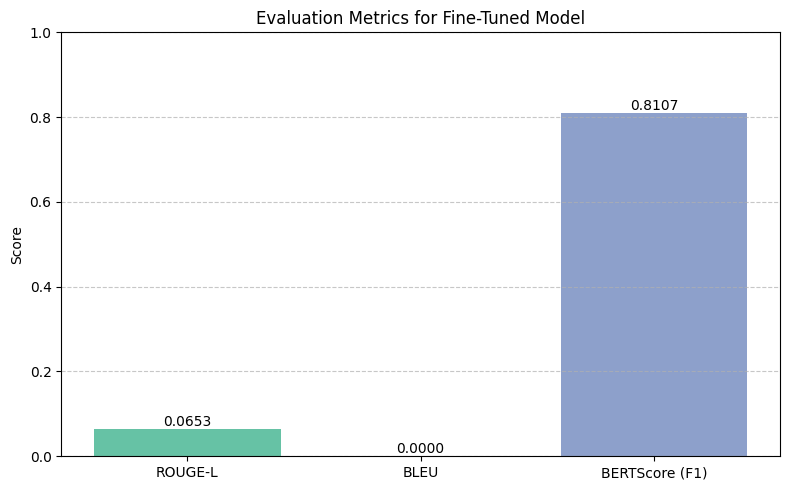

In [ ]:
import matplotlib.pyplot as plt

#Compute metrics
rouge_result = rouge.compute(predictions=preds, references=refs)
bleu_result = bleu.compute(predictions=preds, references=refs)
bertscore_result = bertscore.compute(predictions=preds, references=refs, lang="en")

#Extract relevant values
metrics = ['ROUGE-L', 'BLEU', 'BERTScore (F1)']
scores = [
    rouge_result['rougeL'],
    bleu_result['bleu'],
    sum(bertscore_result['f1']) / len(bertscore_result['f1'])  # average F1 score
]

#Bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores, color=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title("Evaluation Metrics for Fine-Tuned Model")
plt.ylabel("Score")
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
!pip install together
import together

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
import time

In [ ]:
#LLM-as-a-Judge via Together.ai

together.api_key = "YOUR-API-KEY"

prompt_template = """
Evaluate the summary on:
1. Fluency (1-5)
2. Factuality (1-5)
3. Coverage (1-5)

Provide a short justification for each rating.

Input: {input_text}
Summary: {generated_summary}
"""

#Select only one random sample for evaluation
sample_idx = sample_indices[0]  #Take just one sample from the indices

#Limit the input text and summary tokens to smaller sizes
input_text = TOKENIZER.decode(test_data[sample_idx]["input_ids"], skip_special_tokens=True)[:400]
summary = preds[0]  #Take the first summary

prompt = prompt_template.format(input_text=input_text, generated_summary=summary)

#Make the request to Together.ai for evaluation with further reduced tokens
response = together.Complete.create(
    model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
    prompt=prompt,
    max_tokens=500,
    temperature=0.7,
)

# Extract the response text
response_text = response['choices'][0]['text']

# Output the evaluation result for the single sample
print(f"\n Evaluation for Sample:\n{response_text}")

time.sleep(1)

<ipython-input-54-7bf6adde9e43>:27: DeprecationWarning: Call to deprecated function create.
  response = together.Complete.create(



 Evaluation for Sample:
The summary is: "inhomogeneous npdf distributions".

To evaluate the given summary, we will assess it based on three criteria: Fluency, Factuality, and Coverage.

## Step 1: Evaluate Fluency (1-5)
Fluency refers to how well the summary is written in terms of clarity, grammar, and readability. The given summary, "inhomogeneous npdf distributions," is concise and grammatically correct but lacks context. It is a phrase rather than a complete sentence, which might affect its fluency. However, it is still understandable. Rating: 4 (because it's concise and clear but not a complete sentence).

## Step 2: Evaluate Factuality (1-5)
Factuality assesses whether the summary accurately represents the facts presented in the original text. The original text discusses nuclear parton distribution functions (npdfs) and their importance. The summary mentions "inhomogeneous npdf distributions," which is related to the topic but not directly stated in the original text. The origin

In [ ]:
!pip install langchain langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install langchain langgraph openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 19.0 MB/s eta 0:00:00


# KeywordAgent

In [ ]:
from langchain.llms import OpenAI
from langchain.agents import Tool, AgentExecutor
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
import os

In [ ]:
from langchain.llms import Together

# Set your Together API Key
import os
os.environ["TOGETHER_API_KEY"] = "YOUR-API-KEY"

# Initialize the Together LLM (example using Mistral)
llm = Together(
    model="mistralai/Mistral-7B-Instruct-v0.2",
    temperature=0.7,
    max_tokens=512
)

<ipython-input-62-6516fc25e7f0>:8: LangChainDeprecationWarning: The class `Together` was deprecated in LangChain 0.0.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-together package and should be used instead. To use it run `pip install -U :class:`~langchain-together` and import as `from :class:`~langchain_together import Together``.
  llm = Together(


In [ ]:
# Define Prompt
keyword_prompt = PromptTemplate.from_template(
    """
    You are a research assistant. Given the input keyword(s): "{user_input}", generate a list of related and expanded research keywords and phrases that can improve academic paper searches.

    Format the response as a numbered list of keywords.
    """
)

In [ ]:
keyword_agent = LLMChain(llm=llm, prompt=keyword_prompt)

<ipython-input-65-4863e2aac820>:1: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  keyword_agent = LLMChain(llm=llm, prompt=keyword_prompt)


In [ ]:
expanded_keywords = keyword_agent.run({"user_input": "artificial neural network"})
print(expanded_keywords)

<ipython-input-66-2cc1d1802efa>:1: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  expanded_keywords = keyword_agent.run({"user_input": "artificial neural network"})


1. Deep Learning
    2. Convolutional Neural Network (CNN)
    3. Recurrent Neural Network (RNN)
    4. Long Short-Term Memory (LSTM)
    5. Autoencoders
    6. Generative Adversarial Networks (GAN)
    7. Backpropagation
    8. Activation Functions
    9. Optimization Algorithms (SGD, Adam, RMSprop)
    10. Neural Network Architectures
    11. Hyperparameter Tuning
    12. Transfer Learning
    13. Neural Turing Machines (NTM)
    14. Spiking Neural Networks (SNN)
    15. Reinforcement Learning (RL)
    16. Unsupervised Learning
    17. Semi-Supervised Learning
    18. Multi-Layer Perceptron (MLP)
    19. Boltzmann Machines (BM)
    20. Restricted Boltzmann Machines (RBM)
    21. Hopfield Networks
    22. Echo State Networks (ESN)
    23. Radial Basis Function Networks (RBFN)
    24. Support Vector Machines (SVM) compared to Artificial Neural Networks
    25. Neural Network Applications (computer vision, speech recognition, natural language processing)
    26. Neural Network Limitatio

# SearchAgent

In [ ]:
!pip install feedparser

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=2c39f104f6eeeacfafcbd72173324caf9f12881526b4b53c70077b88eecef150
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


In [ ]:
import feedparser
import urllib.parse

class SearchAgent:
    def __init__(self, max_results=10):
        self.base_url = "http://export.arxiv.org/api/query?"
        self.max_results = max_results

    def search_arxiv(self, keywords):
        # Create the query string with 'OR' joining the keywords
        query = "+OR+".join([f"all:{kw}" for kw in keywords])

        # URL encode the query string to prevent any issues with special characters
        encoded_query = urllib.parse.quote(query)

        # Construct the full URL with the encoded query
        url = f"{self.base_url}search_query={encoded_query}&start=0&max_results={self.max_results}"

        # Parse the feed
        feed = feedparser.parse(url)
        papers = []

        for entry in feed.entries:
            paper = {
                "title": entry.title,
                "abstract": entry.summary,
                "authors": [author.name for author in entry.authors],
                "published": entry.published,
                "link": entry.link
            }
            papers.append(paper)

        return papers

In [ ]:
expanded_keywords = ["Deep learning", "Reinforcement Learning", "Hyperparameter optimization"]

# Initialize the SearchAgent
search_agent = SearchAgent(max_results=5)

# Search arXiv
papers = search_agent.search_arxiv(expanded_keywords)

# Print the results
for i, paper in enumerate(papers, 1):
    print(f"\nPaper {i}:")
    print(f"Title: {paper['title']}")
    print(f"Authors: {', '.join(paper['authors'])}")
    print(f"Published: {paper['published']}")
    print(f"Abstract: {paper['abstract'][:300]}...")  # Limiting abstract length for readability
    print(f"Link: {paper['link']}")


Paper 1:
Title: Deep Inverse Optimization
Authors: Yingcong Tan, Andrew Delong, Daria Terekhov
Published: 2018-12-03T14:56:57Z
Abstract: Given a set of observations generated by an optimization process, the goal of
inverse optimization is to determine likely parameters of that process. We cast
inverse optimization as a form of deep learning. Our method, called deep
inverse optimization, is to unroll an iterative optimization process ...
Link: http://arxiv.org/abs/1812.00804v1

Paper 2:
Title: Optimization Methods in Deep Learning: A Comprehensive Overview
Authors: David Shulman
Published: 2023-02-19T13:01:53Z
Abstract: In recent years, deep learning has achieved remarkable success in various
fields such as image recognition, natural language processing, and speech
recognition. The effectiveness of deep learning largely depends on the
optimization methods used to train deep neural networks. In this paper, we
provid...
Link: http://arxiv.org/abs/2302.09566v2

Paper 3:
Title: A Novel Str

# RankAgent

In [ ]:
!pip install requests

In [ ]:
import requests
import time
from datetime import datetime

class RankAgent:
    def __init__(self, relevance_threshold=0.5):
        self.relevance_threshold = relevance_threshold

    def score_paper(self, paper, keywords):
        """
        Score each paper based on:
        - Citation count (if available)
        - Publication date (newer papers rank higher)
        - Relevance to the input keywords (inferred by an LLM API)
        """
        score = 0

        # Citation count: If available, higher citations get a higher score
        citation_count = paper.get("citations", 0)
        score += citation_count * 0.3

        published_date_str = paper["published"]
        published_date = datetime.strptime(published_date_str, "%Y-%m-%dT%H:%M:%SZ")

        current_date = datetime.utcnow()
        date_diff = (current_date - published_date).days
        score += max(0, 100 - date_diff) * 0.4

        abstract = paper["abstract"]
        relevance_score = self.get_relevance_score(abstract, keywords)
        score += relevance_score * 0.3

        return score

    def get_relevance_score(self, abstract, keywords):
        """
        Calculate the relevance score of the paper's abstract to the input keywords.
        Use Together.ai API for inference.
        """
        keyword_string = ", ".join(keywords)
        relevance_score = self.calculate_relevance_with_llm(abstract, keyword_string)
        return relevance_score

    def calculate_relevance_with_llm(self, abstract, keyword_string):
        """
        Use Together.ai to compute a relevance score between abstract and keywords.
        """

        api_key = "YOUR-API-KEY"
        endpoint = "https://api.together.xyz/inference"

        prompt = f"""Rate the relevance of the following abstract to these keywords on a scale from 0 to 1:

        Keywords: {keyword_string}

        Abstract: {abstract}

        Relevance score (only a number between 0 and 1):"""

        payload = {
        "model": "togethercomputer/llama-2-70b-chat",
        "prompt": prompt,
        "max_tokens": 5,
        "temperature": 0.0
        }

        headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
        }

        try:
          response = requests.post("https://api.together.xyz/inference", json=payload, headers=headers)
          response.raise_for_status()
          result_text = response.json()["choices"][0]["text"].strip()
          relevance_score = float(result_text)
          return min(max(relevance_score, 0), 1)
        except Exception as e:
          print(f"Error from Together.ai API: {e}")
          return 0.5



    def rank_papers(self, papers, keywords):
        scored_papers = []
        for paper in papers:
            score = self.score_paper(paper, keywords)
            paper["score"] = score
            scored_papers.append(paper)

        ranked_papers = sorted(scored_papers, key=lambda x: x["score"], reverse=True)
        return ranked_papers

In [ ]:
#Rank the papers
rank_agent = RankAgent()
ranked_papers = rank_agent.rank_papers(papers, expanded_keywords)

print("\nAll Ranked Papers:")
for i, paper in enumerate(ranked_papers, 1):
        print(f"\nPaper {i}:")
        print(f"Title: {paper['title']}")
        print(f"Authors: {', '.join(paper['authors'])}")
        print(f"Published: {paper['published']}")
        print(f"Link: {paper['link']}")
        print(f"Score: {paper['score']:.4f}")

#Show top 2 papers
print("\nTop 2 Papers:")
for i, paper in enumerate(ranked_papers[:2], 1):
        print(f"\nTop Paper {i}:")
        print(f"Title: {paper['title']}")
        print(f"Authors: {', '.join(paper['authors'])}")
        print(f"Published: {paper['published']}")
        print(f"Link: {paper['link']}")
        print(f"Score: {paper['score']:.4f}")

Error from Together.ai API: 400 Client Error: Bad Request for url: https://api.together.xyz/inference
Error from Together.ai API: 400 Client Error: Bad Request for url: https://api.together.xyz/inference
Error from Together.ai API: 429 Client Error: Too Many Requests for url: https://api.together.xyz/inference
Error from Together.ai API: 429 Client Error: Too Many Requests for url: https://api.together.xyz/inference
Error from Together.ai API: 429 Client Error: Too Many Requests for url: https://api.together.xyz/inference

All Ranked Papers:

Paper 1:
Title: Deep Inverse Optimization
Authors: Yingcong Tan, Andrew Delong, Daria Terekhov
Published: 2018-12-03T14:56:57Z
Link: http://arxiv.org/abs/1812.00804v1
Score: 0.1500

Paper 2:
Title: Optimization Methods in Deep Learning: A Comprehensive Overview
Authors: David Shulman
Published: 2023-02-19T13:01:53Z
Link: http://arxiv.org/abs/2302.09566v2
Score: 0.1500

Paper 3:
Title: A Novel Structured Natural Gradient Descent for Deep Learning
A

# SummaryAgent

In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
# Use the same tokenizer and model already defined above
model.to("cuda")  # if not already
tokenizer = TOKENIZER  # already loaded

from transformers import pipeline
summarizer = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

Device set to use cuda:0
The model 'PeftModelForSeq2SeqLM' is not supported for text2text-generation. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGen

In [ ]:
model.save_pretrained("finetuned-t5-lora")
tokenizer.save_pretrained("finetuned-t5-lora")

('finetuned-t5-lora/tokenizer_config.json',
 'finetuned-t5-lora/special_tokens_map.json',
 'finetuned-t5-lora/spiece.model',
 'finetuned-t5-lora/added_tokens.json',
 'finetuned-t5-lora/tokenizer.json')

In [ ]:
from peft import PeftModel
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

base_model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL)
model = PeftModel.from_pretrained(base_model, "finetuned-t5-lora")
tokenizer = AutoTokenizer.from_pretrained("finetuned-t5-lora")

In [ ]:
class SummaryAgent:
    def __init__(self, summarizer_pipeline):
        self.summarizer = summarizer_pipeline

    def summarize_paper(self, paper):
        abstract = paper["abstract"]
        title = paper["title"]
        authors = ", ".join(paper["authors"])
        published = paper["published"]

        prompt = f"""
        You are a research assistant. Read the paper details below and generate a structured academic summary with the following sections:
        - Title
        - Authors
        - Date
        - Abstract Summary
        - Core Ideas
        - Possible Applications
        - Limitations or Challenges (if any)

        Paper Metadata:
        Title: {title}
        Authors: {authors}
        Published: {published}
        Abstract: {abstract}
        """

        try:
            result = self.summarizer(prompt, max_new_tokens=512, do_sample=True, temperature=0.7)[0]
            summary = result["generated_text"]
            return summary.strip()
        except Exception as e:
            print(f"Error during summarization: {e}")
            return "Summary could not be generated due to an error."

    def summarize_papers(self, papers):
        summaries = {}
        for i, paper in enumerate(papers, 1):
            print(f"\nSummarizing Paper {i}: {paper['title']}")
            summary = self.summarize_paper(paper)
            summaries[paper['title']] = summary
        return summaries

In [ ]:
top_papers = ranked_papers[:2]
summary_agent = SummaryAgent(summarizer)
summaries = summary_agent.summarize_papers(top_papers)

for title, summary in summaries.items():
    print(f"\nSummary for: {title}\n{summary}\n{'-'*60}")


Summarizing Paper 1: Deep Inverse Optimization

Summarizing Paper 2: Optimization Methods in Deep Learning: A Comprehensive Overview

Summary for: Deep Inverse Optimization
We use backpropagating to learn the coefficients determining the cost vector and the constraints for both non-parametric and parametric linear programs.
------------------------------------------------------------

Summary for: Optimization Methods in Deep Learning: A Comprehensive Overview
The basic work of deep learning optimization.
------------------------------------------------------------
